# Optymalizacja Wielokryterialnia | Lab 4 - Ćw. 3. Metody skalaryzacji
04.11.2024r.

Zespół:
- Krzysztof Kordal
- Szymon Szewczyk
- Łukasz Szyszka

In [1]:
# Import bibliotek
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# TURN ON For interactive plots (ipympl)
# %matplotlib widget

## Definiowanie Funkcji Celu

In [2]:
# Definicja funkcji celu
def f1(x):
    return x[0]**2 + (x[1]+0.2)**2

def f2(x):
    return (x[0]-1)**2 + (x[1]+1)**2

def g1(x):
    return x[0]**2 + x[1]**2 + x[2]**2

def g2(x):
    return (x[0]-1)**2 + (x[1]+1)**2 + x[2]**2

def g3(x):
    return x[0]**3 - x[1]**2 + x[2]**2

## Metody Skalaryzacji

In [3]:
# 1. Skalowanie przez funkcję liniową
def linear_scaling(F, lambdas, x):
    return sum(lambdas[i] * F[i](x) for i in range(len(F)))

# 2. Skalowanie metodą ε-ograniczeń
def epsilon_constraints(F, x, epsilons, idx):
    constraints = [{'type': 'ineq', 'fun': lambda x: epsilons[i] - F[i](x)} for i in range(len(F)) if i != idx]
    return F[idx](x), constraints

# 3. Skalowanie przez odległość od punktu dominującego
def distance_scaling(F, x, x0_target, lambdas, p_norm):
    if p_norm == np.inf:
        norm = np.max( lambdas[i] * np.abs(F[i](x) - x0_target[i]) for i in range(len(F)) )
    else:
        norm = sum( lambdas[i] * np.abs(F[i](x) - x0_target[i])**p_norm for i in range(len(F))) ** (1./p_norm)
    return norm

### Opakowania metod, do wywoływania scipy.minimize()

In [4]:
def run_linear_scaling(F, lambdas, x0, bounds, callback_fun = None):
    return minimize(lambda x: linear_scaling(F, lambdas, x), x0,
                    bounds=bounds,
                    callback=callback_fun)

def run_epsilon_constraints(F, epsilons, idx, x0, bounds, callback_fun = None):
    # F[idx] output not used here, only constraints needed
    _, constraints = epsilon_constraints(F, x0, epsilons, idx)
    return minimize(F[idx], x0, constraints=constraints,
                    bounds=bounds,
                    callback=callback_fun)

def run_distance_scaling(F, x0_target, lambdas, p_norm, x0, bounds, callback_fun = None):
    return minimize(lambda x: distance_scaling(F, x, x0_target, lambdas, p_norm), x0,
                    bounds=bounds,
                    callback=callback_fun)

## Optymalizacja dla problemu 2 i 3-kryterialnego

In [5]:
# Obszaru przeszukiwania (dysk jednostkowy w R^2 i R^3)
# - do weryfikacji początkowych x0
def is_in_U(x, dim):
    return np.linalg.norm(x) <= 1 if dim == 2 else np.linalg.norm(x) <= np.sqrt(2)

In [6]:
# Aproksymacja zbiorów Pareto dla dwóch kryteriów
def pareto_approximation_2d(F, method, F_all, steps, idx=0):
    points = []

    # obszar przeszukiwania - kwadrat 2D
    bounds = [(-1, 1), (-1, 1)]

    # przygotowanie lambdas & epsilons
    lambdas = np.linspace(0.05, 0.95, steps)
    epsilons = np.column_stack([np.linspace(min(F_all[:,0]), max(F_all[:,0]), steps),
                                np.linspace(min(F_all[:,1]), max(F_all[:,1]), steps)])

    for i in range(steps):
        # x0 = np.random.rand(2) * 2 - 1
        x0 = [0,0]
        if is_in_U(x0, 2):
            if method == 'linear':
                res = run_linear_scaling(F, [lambdas[i], 1-lambdas[i]], x0, bounds)
                # res = minimize(lambda x: linear_scaling(F, [i, 1 - i], x), x0)
            elif method == 'epsilon':
                res = run_epsilon_constraints(F, epsilons[i], idx, x0, bounds)
                # res = epsilon_constraints(F, x0, [1, 1], 0)
            elif method == 'distance':
                res = run_distance_scaling(F, [0,0], [lambdas[i], 1-lambdas[i]], 2, x0, bounds)
                # res = minimize(lambda x: distance_scaling(F, x, [0, 0], [i, 1 - i], 2), x0)
            if res.success:
                points.append(res.x)
    return np.array(points)

# Aproksymacja zbiorów Pareto dla trzech kryteriów
def pareto_approximation_3d(G, method, G_all, steps, idx=0):
    points = []

    # obszar przeszukiwania - kwadrat 3D
    bounds = [(-1, 1), (-1, 1), (-1, 1)]
    
    # przygotowanie lambdas & epsilons
    lambdas = np.linspace(0.05, 0.95, steps)
    epsilons = np.column_stack([np.linspace(min(G_all[:,0]), max(G_all[:,0]), steps),
                                np.linspace(min(G_all[:,1]), max(G_all[:,1]), steps),
                                np.linspace(min(G_all[:,2]), max(G_all[:,2]), steps)])
    
    for i in range(steps):
        # x0 = np.random.rand(3) * 2 - 1
        x0 = [0,0,0]
        if is_in_U(x0, 3):
            if method == 'linear':
                res = run_linear_scaling(G, [lambdas[i], (1-lambdas[i])/2, (1-lambdas[i])/2], x0, bounds)
                # res = minimize(lambda x: linear_scaling(G, [i, 1 - i, i/2], x), x0)
            elif method == 'epsilon':
                res = run_epsilon_constraints(G, epsilons[i], idx, x0, bounds)
                # res = epsilon_constraints(G, x0, [1, 1, 1], 0)
            elif method == 'distance':
                res = run_distance_scaling(G, [0,0,0], [lambdas[i], (1-lambdas[i])/2, (1-lambdas[i])/2], 2, x0, bounds)
                # res = minimize(lambda x: distance_scaling(G, x, [0, 0, 0], [i, 1 - i, i/2], 2), x0)
            if res.success:
                points.append(res.x)
    return np.array(points)

## Wywołanie

### Przygotowanie przestrzeni
(do porównania na wykresach i wyznaczenia epsilonów)

In [7]:
# Generuj przestrzeń funkcji celu 2D
x_vals = np.linspace(-1, 1, 30)
y_vals = np.linspace(-1, 1, 30)
X, Y = np.meshgrid(x_vals, y_vals)
U_grid_2D = np.column_stack([X.ravel(), Y.ravel()])
# Oblicz wartości punktów dla kryteriów składowych
F_all_values = np.array([[f1(x), f2(x)] for x in U_grid_2D])

# Generuj przestrzeń funkcji celu 3D
x_vals = np.linspace(-1, 1, 20)
y_vals = np.linspace(-1, 1, 20)
z_vals = np.linspace(-1, 1, 20)
X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)
U_grid_3D = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])
# Oblicz wartości punktów dla kryteriów składowych
G_all_values = np.array([[g1(x), g2(x), g3(x)] for x in U_grid_3D])

In [8]:
# Wywołanie dla dwukryterialnego problemu
F = [f1, f2]
points_linear_2d   = pareto_approximation_2d(F, 'linear',   F_all_values, 50)
points_epsilon_2d  = pareto_approximation_2d(F, 'epsilon',  F_all_values, 50, idx=0)
points_distance_2d = pareto_approximation_2d(F, 'distance', F_all_values, 50)

pareto_values_linear_2d   = np.column_stack([F[0](points_linear_2d.T), F[1](points_linear_2d.T)])
pareto_values_epsilon_2d  = np.column_stack([F[0](points_epsilon_2d.T), F[1](points_epsilon_2d.T)])
pareto_values_distance_2d = np.column_stack([F[0](points_distance_2d.T), F[1](points_distance_2d.T)])

# Wywołanie dla trzykryterialnego problemu
G = [g1, g2, g3]
points_linear_3d   = pareto_approximation_3d(G, 'linear',   G_all_values, 50)
points_epsilon_3d  = pareto_approximation_3d(G, 'epsilon',  G_all_values, 50, idx=0)
points_distance_3d = pareto_approximation_3d(G, 'distance', G_all_values, 50)

# Calculate 
pareto_values_linear_3d   = np.column_stack([G[0](points_linear_3d.T), G[1](points_linear_3d.T), G[2](points_linear_3d.T)])
pareto_values_epsilon_3d  = np.column_stack([G[0](points_epsilon_3d.T), G[1](points_epsilon_3d.T), G[2](points_epsilon_3d.T)])
pareto_values_distance_3d = np.column_stack([G[0](points_distance_3d.T), G[1](points_distance_3d.T), G[2](points_distance_3d.T)])

## Wykresy

In [9]:
# Wizualizacja wyników
def plot_pareto_2d(ax, points, title):
    ax.plot(points[:, 0], points[:, 1],
            linestyle='--', color='red', marker='o', label='Punkty niezdominowane (front Pareto)')
    ax.set(title=title,
           xlabel="f1(x)",
           ylabel="f2(x)")
    ax.grid()
    ax.legend()

def plot_F_values_2D(ax, pareto_points, pareto_F_values, title):
    ax.plot(pareto_points[:, 0], pareto_points[:, 1], pareto_F_values,
            linestyle='--', color='red', marker='o', label='Punkty niezdominowane (front Pareto)')
    ax.set(title=title,
           xlabel="$x_0$",
           ylabel="$x_1$",
           zlabel="F(x)")
    ax.grid()
    ax.legend()

def plot_pareto_3d(ax, points, title):
    ax.plot(points[:, 0], points[:, 1], points[:, 2],
            linestyle='--', color='red', marker='o', label='Punkty niezdominowane (front Pareto)')
    ax.set(title=title,
           xlabel="g1(x)",
           ylabel="g2(x)",
           zlabel="g3(x)")
    ax.legend()

### Dwukryterialne

#### Wykresy z frontami Pareto (osie=wartości kryteriów)

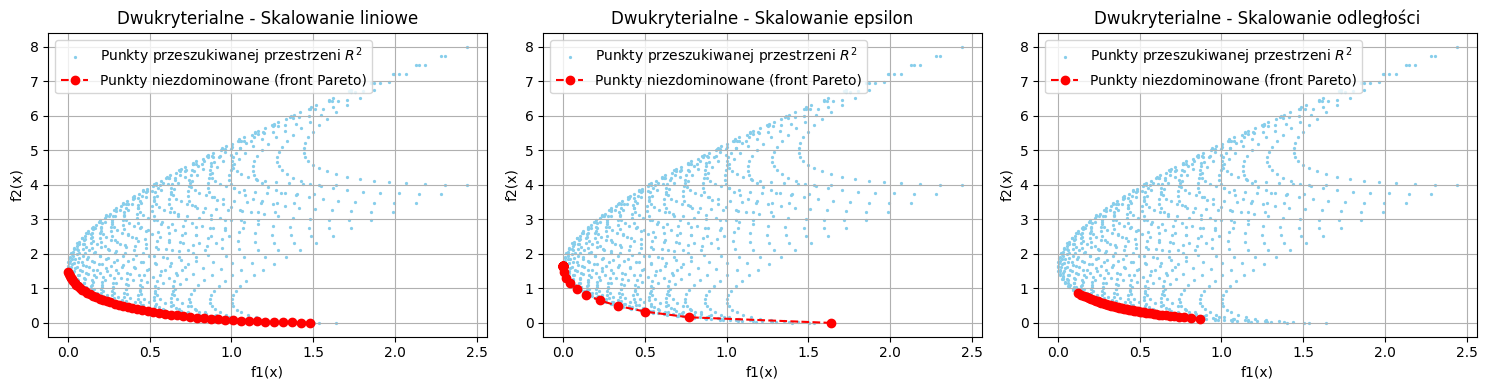

In [10]:
# Clear figures from memory
plt.close("all")

# Wykresy dla dwukryterialnego problemu
fig_2D, axs_2D = plt.subplots(1, 3, figsize=(15, 4))
# przestrzeń punktów funkcji
axs_2D[0].scatter(F_all_values[:,0], F_all_values[:,1], color='skyblue', marker='.', s=7, label='Punkty przeszukiwanej przestrzeni $R^2$')
axs_2D[1].scatter(F_all_values[:,0], F_all_values[:,1], color='skyblue', marker='.', s=7, label='Punkty przeszukiwanej przestrzeni $R^2$')
axs_2D[2].scatter(F_all_values[:,0], F_all_values[:,1], color='skyblue', marker='.', s=7, label='Punkty przeszukiwanej przestrzeni $R^2$')
# punkty niezdominowane
plot_pareto_2d(axs_2D[0], pareto_values_linear_2d, "Dwukryterialne - Skalowanie liniowe")
plot_pareto_2d(axs_2D[1], pareto_values_epsilon_2d, "Dwukryterialne - Skalowanie epsilon")
plot_pareto_2d(axs_2D[2], pareto_values_distance_2d, "Dwukryterialne - Skalowanie odległości")
fig_2D.tight_layout()
plt.show()

#### Wykresy wartości funkcji F(x) (poglądowe)

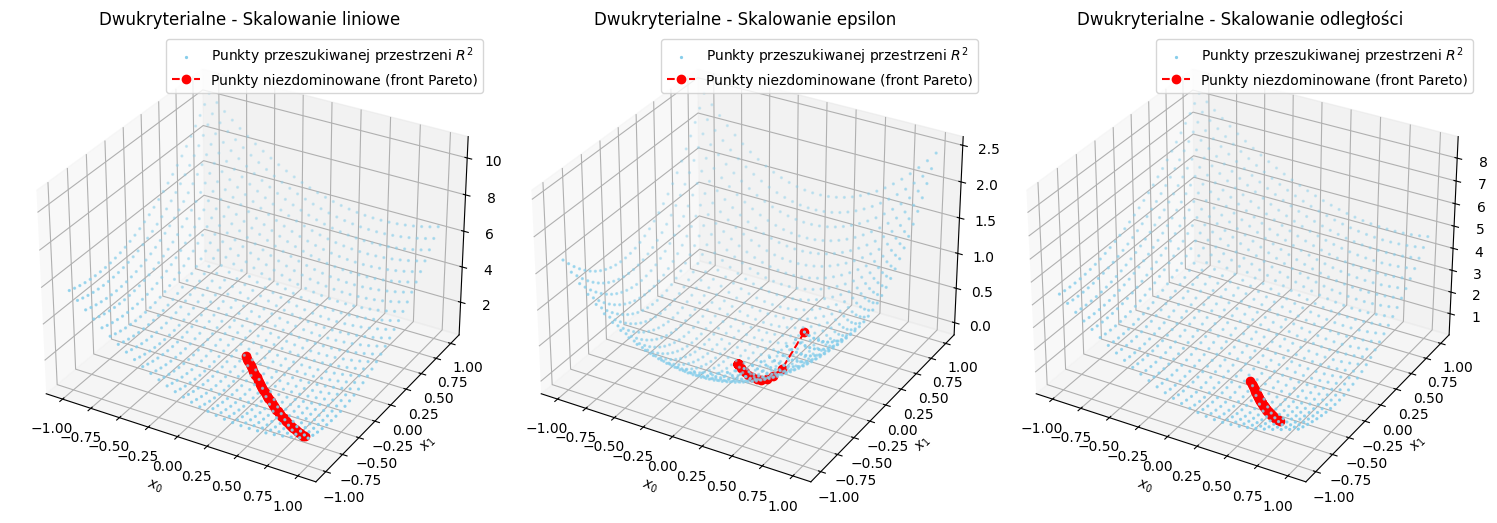

In [13]:

# Wykresy dla dwukryterialnego problemu
fig_2D_1, axs_2D_1 = plt.subplots(1, 3, figsize=(15, 6), subplot_kw={'projection': '3d'})

# przygotowanie punktów przestrzeni
F_linear_values = [linear_scaling(F, [1,1], x) for x in U_grid_2D]
F_epsilon_values = [epsilon_constraints(F, x, [1,1], idx=0)[0] for x in U_grid_2D]
F_distance_values = [distance_scaling(F, x, [0,0], [1,1], 2) for x in U_grid_2D]
# przygotowanie punktów niezdominowanych
F_linear_pareto_values   = [linear_scaling(F, [1,1], x) for x in points_linear_2d]
F_epsilon_pareto_values  = [epsilon_constraints(F, x, [1,1], idx=0)[0] for x in points_epsilon_2d]
F_distance_pareto_values = [distance_scaling(F, x, [0,0], [1,1], 2) for x in points_distance_2d]

# przestrzeń punktów funkcji
axs_2D_1[0].scatter(U_grid_2D[:,0], U_grid_2D[:,1], F_linear_values, color='skyblue', marker='.', s=7, label='Punkty przeszukiwanej przestrzeni $R^2$')
axs_2D_1[1].scatter(U_grid_2D[:,0], U_grid_2D[:,1], F_epsilon_values, color='skyblue', marker='.', s=7, label='Punkty przeszukiwanej przestrzeni $R^2$')
axs_2D_1[2].scatter(U_grid_2D[:,0], U_grid_2D[:,1], F_distance_values, color='skyblue', marker='.', s=7, label='Punkty przeszukiwanej przestrzeni $R^2$')
# punkty niezdominowane
plot_F_values_2D(axs_2D_1[0], points_linear_2d, F_linear_pareto_values, "Dwukryterialne - Skalowanie liniowe")
plot_F_values_2D(axs_2D_1[1], points_epsilon_2d, F_epsilon_pareto_values, "Dwukryterialne - Skalowanie epsilon")
plot_F_values_2D(axs_2D_1[2], points_distance_2d, F_distance_pareto_values, "Dwukryterialne - Skalowanie odległości")

fig_2D_1.tight_layout()

### Trzykryterialne - wykresy z frontami Pareto

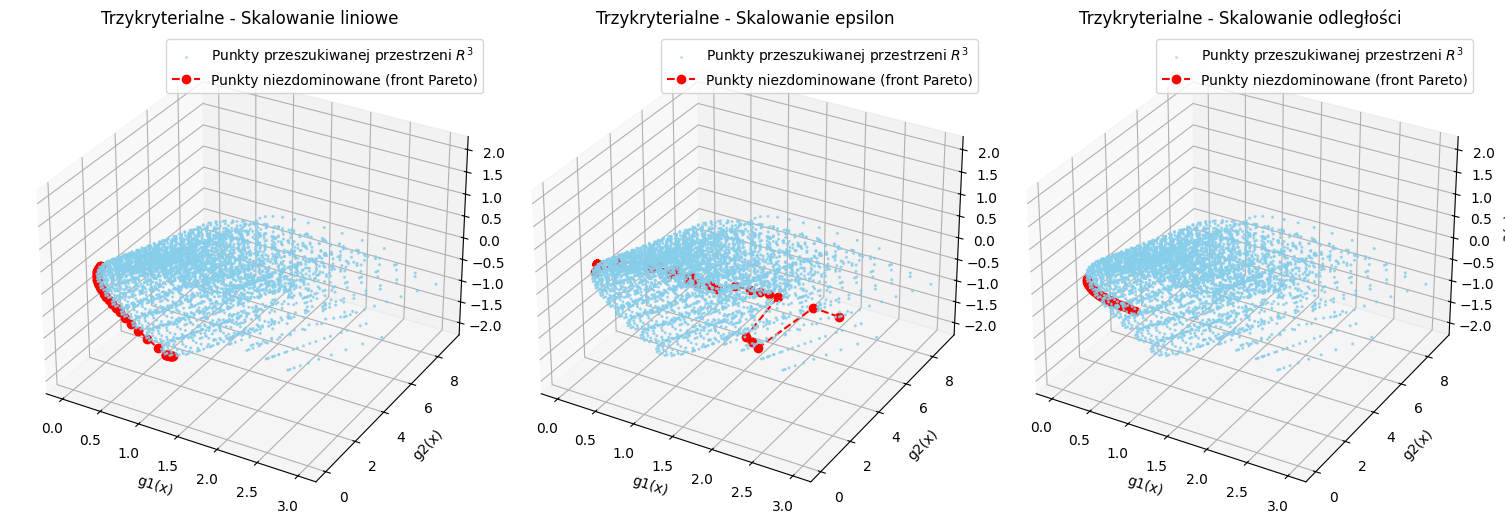

In [12]:
# Wykresy dla trzykryterialnego problemu
fig_3D, axs_3D = plt.subplots(1, 3, figsize=(15, 6), subplot_kw={'projection': '3d'})
axs_3D[0].scatter(G_all_values[:,0], G_all_values[:,1], G_all_values[:,2], color='skyblue', marker='.', s=5, alpha=0.5, label='Punkty przeszukiwanej przestrzeni $R^3$')
axs_3D[1].scatter(G_all_values[:,0], G_all_values[:,1], G_all_values[:,2], color='skyblue', marker='.', s=5, alpha=0.5, label='Punkty przeszukiwanej przestrzeni $R^3$')
axs_3D[2].scatter(G_all_values[:,0], G_all_values[:,1], G_all_values[:,2], color='skyblue', marker='.', s=5, alpha=0.5, label='Punkty przeszukiwanej przestrzeni $R^3$')
# punkty niezdominowane
plot_pareto_3d(axs_3D[0], pareto_values_linear_3d, "Trzykryterialne - Skalowanie liniowe")
plot_pareto_3d(axs_3D[1], pareto_values_epsilon_3d, "Trzykryterialne - Skalowanie epsilon")
plot_pareto_3d(axs_3D[2], pareto_values_distance_3d, "Trzykryterialne - Skalowanie odległości")
fig_3D.tight_layout()
plt.show()